In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
import lightgbm
import catboost
import sklearn.svm

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
data_all_old = pd.read_excel('Data/data_2_samples_NEW.xlsx', index_col=0)
# Drop sample 1
data_all_old = data_all_old[data_all_old['sample']==0]
# Reneme coluns the same as in new data
data_all_old.drop(['sample', 'AGT_AGTR2'], axis=1, inplace=True)
data_all_old.rename(columns={'stage_agr': 'stage'}, inplace=True)
# Change order of columns (other order causes error in xgboost)
data_all_old = data_all_old[['gender', 'age', 'bmi', 'ao','activity', 
                             'smoking', 'male_heredity', 'stage']]
data_all_old.head()

,gender,age,bmi,ao,activity,smoking,male_heredity,stage
0,0,0,0,0,0,0,1,1
1,1,1,0,0,1,1,0,1
2,1,1,0,1,1,1,0,1
3,1,0,1,1,1,0,0,1
4,0,1,1,1,0,0,0,1


In [3]:
data_old = pd.read_csv('Data\data_decode_old.csv', index_col=0).drop('alcohol', axis=1)
data_old.head()

,gender,age,bmi,ao,activity,smoking,male_heredity,stage
0,1,1,0,1,1,1,0,1
1,1,0,1,1,1,0,1,1
2,0,1,0,1,1,1,0,1
3,0,1,0,0,1,0,1,0
4,1,1,1,1,0,1,1,1


In [4]:
data_new = pd.read_csv('Data\data_decode_new.csv', index_col=0).drop('alcohol', axis=1)
data_new.head()

,gender,age,bmi,ao,activity,smoking,male_heredity,stage
0,1,1,0,0,0,1,0,1
1,1,0,0,1,1,0,1,1
2,0,1,1,1,0,0,0,1
3,0,1,0,1,0,0,1,0
4,1,1,0,1,0,1,1,1


## Train models
- Train - old data
- Validate - old data
- Test - new data

In [5]:
# (X_train, X_valid,
# y_train, y_valid) = train_test_split(data_old.drop(['stage'], axis=1),
#                                     data_old['stage'], test_size=0.3,
#                                     random_state=42, stratify=data_old['stage'])

In [6]:
(X_train, X_valid,
 y_train, y_valid) = train_test_split(data_all_old.drop(['stage'], axis=1),
                                     data_all_old['stage'], test_size=0.3,
                                     random_state=42, stratify=data_all_old['stage'])

In [7]:
def find_treshhold(y, y_prob, plot=True):
    x1 = np.linspace(0.1, 0.9, 100)
    y1 = []
    y2 = []
    y3 = []
    for th in x1:
        y_pred = list(map(lambda x: 1 if x > th else 0, y_prob))
        y1.append(metrics.f1_score(y, y_pred))
        y2.append(metrics.recall_score(y, y_pred))
        y3.append(metrics.precision_score(y, y_pred))
    
    max_in = x1[np.argmax(y1)]
    #print(f'Treseshold: {max_in:.5}')
    if plot is False:
        return max_in
    
    plt.figure(figsize=(12, 10))
    plt.plot(x1, y1, label='f1')
    plt.plot(x1, y2, label='req')
    plt.plot(x1, y3, label='pres')
    plt.legend()
    plt.show()
    
    return max_in

In [8]:
def get_metrics(y_test, y_prob, y_pred):
    roc_test = metrics.roc_auc_score(y_test, y_prob)
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    pres = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    F2 = metrics.fbeta_score(y_test, y_pred, 0.2)
    z_o_loss = metrics.zero_one_loss(y_test, y_pred)
    return roc_test,acc, f1, pres, rec, F2, z_o_loss

In [9]:
def get_info(y_test, y_prob, y_pred):
    roc_test, acc, f1, pres, rec, F2, z_o = get_metrics(y_test, y_prob, y_pred)
    info = (f'ROC-AUC score VALID: {roc_test:.2}' + '\n' + 
            f'Accuracy score: {acc:.2}' + '\n' + 
            f'F1 score: {f1:.2}' + '\n' + 
            f'Precision score: {pres:.2}' + '\n' + 
            f'Recall score: {rec:.2}' + '\n' + 
            f'F2 score: {F2:.2}' + '\n' + 
            f'Zero-one loss: {z_o:.2}')
    return info

In [10]:
def get_pred_from_proba(y_proba, threeshold):
    y_pred = list(map(lambda x: 1 if x > threeshold else 0, y_proba))
    return pd.Series(y_pred)

In [11]:
def use_classificator(cls, X_train, X_test, y_train, y_test,
                      threeshold=0.5, choose_th=False, 
                      print_info=True, plot_th=False):
    cls.fit(X_train, y_train)
    if choose_th or plot_th:
        y_prob_train = cls.predict_proba(X_train)[:, 1]
        tmp = find_treshhold(y_train, y_prob_train, plot_th)
        if choose_th:
            threeshold = tmp
        
    y_prob = cls.predict_proba(X_test)[:, 1]        
    y_pred = get_pred_from_proba(y_prob, threeshold)
    
    roc_train = metrics.roc_auc_score(y_train, cls.predict_proba(X_train)[:, 1])
    info = (f'ROC-AUC score TRAIN: {roc_train:.2}' + '\n' + 
            get_info(y_test, y_prob, y_pred))
    
    if print_info:
        print(info)
    
    return threeshold, cls, info, y_pred

In [12]:
def test_model(cls, X_test, y_test, threeshold):
    y_prob = cls.predict_proba(X_test)[:, 1]
    y_pred = get_pred_from_proba(y_prob, threeshold)
    info = get_info(y_test, y_prob, y_pred)
    return info, y_pred

# List of models that I will use:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Classification
- CatBoost
- XGBoost
- LightCBM

In [13]:
list_of_cls = [LogisticRegressionCV(class_weight={0: 1, 1: 3}, solver='liblinear', random_state=42),
               DecisionTreeClassifier(max_depth=5, class_weight={0:1, 1:3}, random_state=42),
               sklearn.svm.SVC(kernel='poly', degree=6, class_weight={0: 1, 1: 3}, probability=True, random_state=42),
               sklearn.svm.SVC(kernel='rbf', probability=True, random_state=42),
               xgboost.XGBClassifier(n_estimators=150, max_depth=2, random_state=42),
               lightgbm.LGBMClassifier(random_state=42, max_depth=5, learning_rate=0.03),
               catboost.CatBoostClassifier(silent=True, depth=2)    
]
threesholds = [None] * len(list_of_cls)
threesholds[0] = 0.75
threesholds[1] = 0.7
threesholds[2] = 0.65
threesholds[3] = 0.62
threesholds[-3] = 0.46
threesholds[-2] = 0.55
threesholds[-1] = 0.5
names = ['Logistic Regression', 'Decision Tree', 'SVM(poly)', 'SVM(rbf)', 'XGBoost', 'LightGBM', 'CatBoost']

In [14]:
table = []
for name, th, cls in zip(names, threesholds, list_of_cls):
    choose_th = True if th is None else False        
    th, cls_fit, res_old, valid_pred = use_classificator(cls, X_train, X_valid,
                                      y_train, y_valid, threeshold=th,
                                      choose_th=choose_th, print_info=False)
    res_new, test_pred = test_model(cls_fit, data_new.drop('stage', axis=1), data_new['stage'], th)
    
    crosstab_valid = str(pd.crosstab(y_valid.reset_index(drop=True), valid_pred))
    crosstab_test = str(pd.crosstab(data_new['stage'], test_pred))
    
    table += [[name + f'\nThreeshold - {th:.4}', res_old, res_new, crosstab_valid, crosstab_test]]
print(tabulate(table, headers=['', 'Old Data', 'New Data', 
                               'Crosstab Validate', 'Crosstab Test'], tablefmt='fancy_grid'))

╒═════════════════════╤═══════════════════════════╤═══════════════════════════╤═════════════════════╤═════════════════╕
│                     │ Old Data                  │ New Data                  │ Crosstab Validate   │ Crosstab Test   │
╞═════════════════════╪═══════════════════════════╪═══════════════════════════╪═════════════════════╪═════════════════╡
│ Logistic Regression │ ROC-AUC score TRAIN: 0.8  │ ROC-AUC score VALID: 0.75 │ col_0   0   1       │ col_0   0    1  │
│ Threeshold - 0.75   │ ROC-AUC score VALID: 0.73 │ Accuracy score: 0.72      │ stage               │ stage           │
│                     │ Accuracy score: 0.72      │ F1 score: 0.81            │ 0      30  29       │ 0      40   55  │
│                     │ F1 score: 0.8             │ Precision score: 0.75     │ 1      20  98       │ 1      24  166  │
│                     │ Precision score: 0.77     │ Recall score: 0.87        │                     │                 │
│                     │ Recall score: 0.

In [15]:
good_names = [names[0]] + names[3:]
good_cls = [list_of_cls[0]] + list_of_cls[3:]
good_ths = [threesholds[0]] + threesholds[3:]

# Feature impotance

In [16]:
fontsize = 14

In [17]:
def draw_feature_impot_catboost(boosting_cls, xlabel='', ylabel='',
                       save=False, name=None, show=True):
    lst_zip = list(zip(boosting_cls.feature_names_,
                       boosting_cls.feature_importances_))
    lst_zip = sorted(lst_zip, key=lambda tup: tup[1], reverse=True)
        
    impot_features = []
    for tup in lst_zip:
        impot_features.append(tup[0])
    impot_features.reverse()
    impot_features

    plt.figure(figsize=(10, 6))

    # Reorder it following the values:
    my_range=range(1,len(lst_zip)+1)

    # Horisontal version
    plt.hlines(y=my_range, xmin=0, xmax=sorted(boosting_cls.feature_importances_),
               color='#badcbe', linewidth=6.0)
    plt.plot(sorted(boosting_cls.feature_importances_),
             my_range, "o", ms=8, color='#549ebb')
    plt.xticks(fontsize=fontsize-2)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    ax = plt.gca()
    plt.yticks(my_range, impot_features, #fontstyle='italic',
               fontsize=fontsize, fontfamily='monospace')
    plt.grid(True)
    ax.set_facecolor('#fbfbfe')
    if save:
        if name is None:
            name = 'img.png'
        plt.savefig(name, edgecolor='none', bbox_inches='tight')
    if show:
        plt.show()

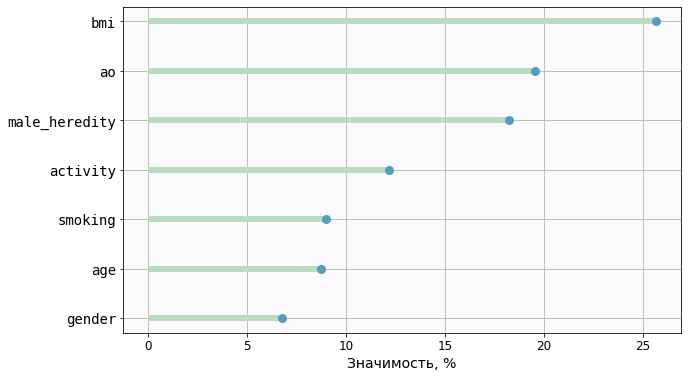

In [18]:
draw_feature_impot_catboost(list_of_cls[-1], xlabel='Значимость, %',
                            save=True, name='graphs/feature_impotance.png')

# Heatmaps

In [ ]:
def draw_heatmap(X, y):
    _, axes = plt.subplots(3, 2, sharey = True, figsize = (12, 18), facecolor='#ffffff')
    sns.set(font_scale=1.3)
    for idx, (name, cls, th) in enumerate(zip(good_names, good_cls, good_ths)):
        cur_ax = axes[idx%3, idx%2]
        y_prob = cls.predict_proba(X)[:, 1]
        counts = pd.crosstab(y.reset_index(drop=True), get_pred_from_proba(y_prob, th))
        sns.heatmap(counts, cmap='GnBu', linewidths=5,
                linecolor='#fbfbfe', xticklabels=['Здоров', 'Болен'],
                yticklabels=['Здоров', 'Болен'], square=True, 
                annot=True, fmt='d', ax=cur_ax)
        cur_ax.set_xlabel('\nПредсказанный класс', fontsize=fontsize+1)
        cur_ax.set_ylabel('Реальный класс\n', fontsize=fontsize+1)
        cur_ax.set_title(name, fontsize=fontsize+3)
    axes[2, 1].set_facecolor('#ffffff')
    axes[2, 1].axis('off')
    plt.savefig('graphs/Heatmap_old.png', edgecolor='none',  bbox_inches='tight')
    plt.show()

### Old data

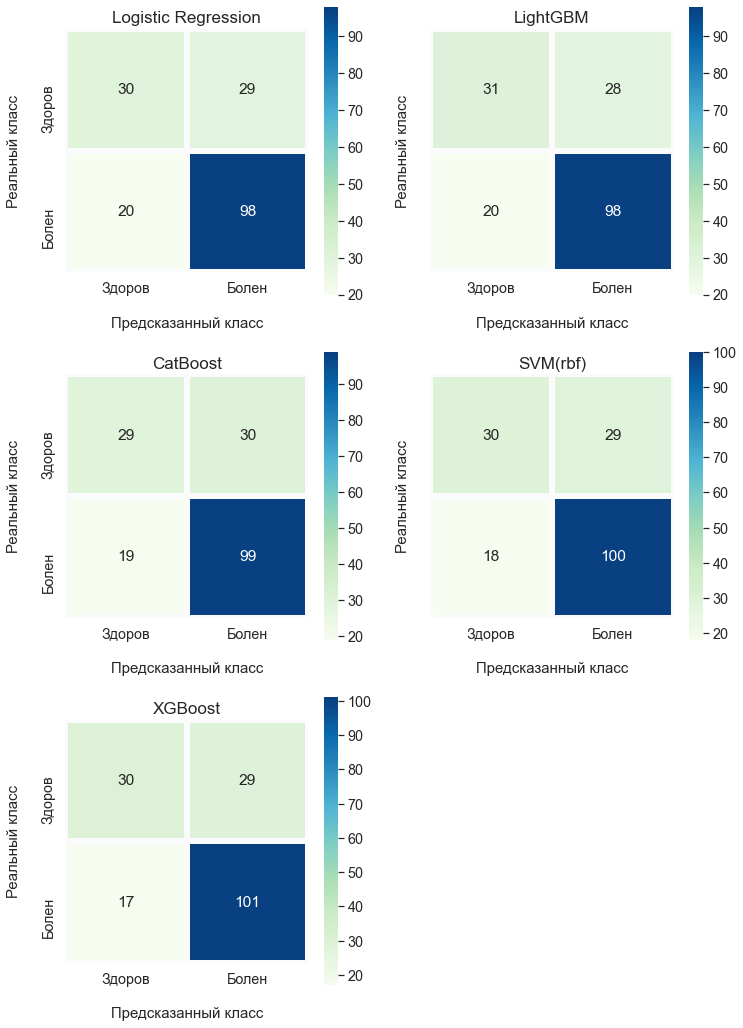

In [20]:
draw_heatmap(X_valid, y_valid)

### New data

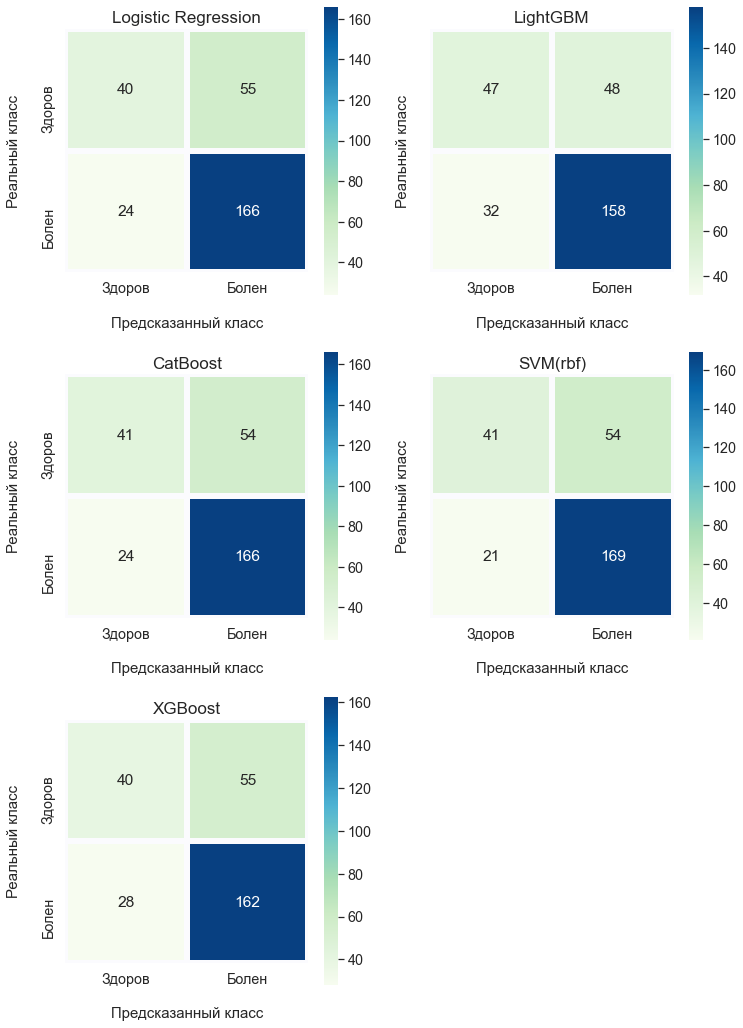

In [22]:
draw_heatmap(data_new.drop('stage', axis=1), data_new.stage)

# Table of percentage

In [35]:
for name, cls, th in zip(good_names, good_cls, good_ths):
    y_prob = cls.predict_proba(data_new.drop('stage', axis=1))[:, 1]
    counts = pd.crosstab(data_new.stage, get_pred_from_proba(y_prob, th))
    print(f'{name}: {counts[0][0] / (counts[0][0]+counts[1][0]):.1%} - new')
    
    y_prob = cls.predict_proba(data_old.drop('stage', axis=1))[:, 1]
    counts = pd.crosstab(data_old.stage, get_pred_from_proba(y_prob, th))
    print(f'{name}: {counts[0][0] / (counts[0][0]+counts[1][0]):.1%} - old')
    print()

Logistic Regression: 42.1% - new
Logistic Regression: 39.7% - old

SVM(rbf): 43.2% - new
SVM(rbf): 42.1% - old

XGBoost: 42.1% - new
XGBoost: 42.9% - old

LightGBM: 49.5% - new
LightGBM: 46.8% - old

CatBoost: 43.2% - new
CatBoost: 41.3% - old



# Hist

In [112]:
def draw_hist(ax, y_true, y_prob, value, threeshold):
    ax.hist(y_prob[y_true==value], color='#549ebb', histtype='bar', alpha=1, bins=50)
    ax.axvline(x=threeshold, color='g', linestyle='--')

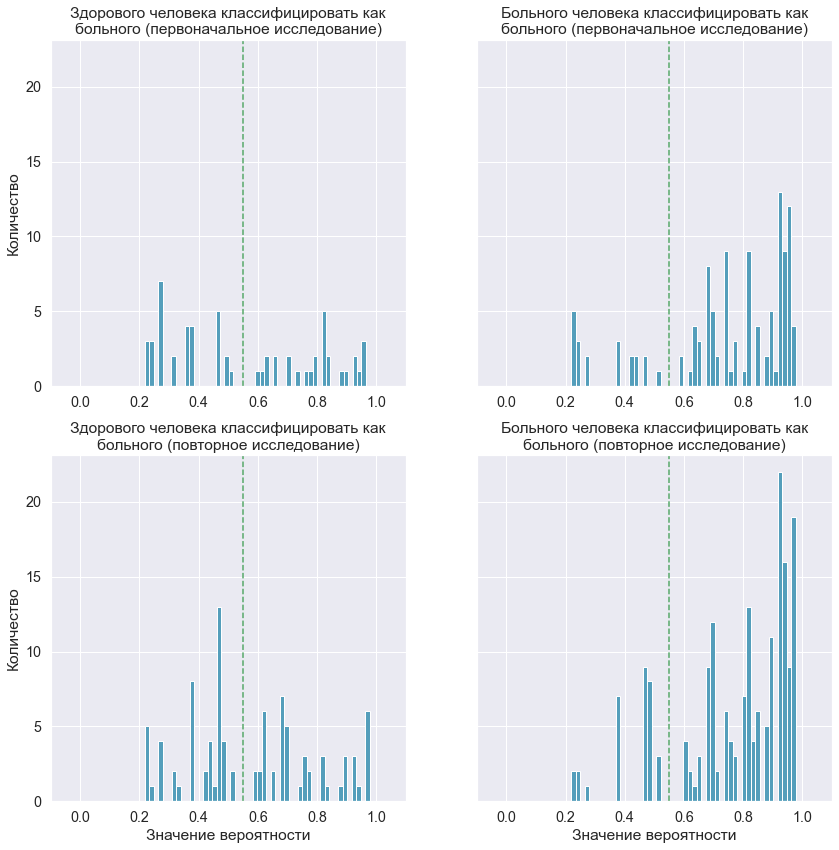

In [114]:
_, axes = plt.subplots(2, 2, sharey = True, figsize = (14, 14), facecolor='#ffffff')
sns.set(font_scale=1.3)
xlabel = 'Значение вероятности'
ylabel = 'Количество'

y_prob_val = good_cls[-2].predict_proba(X_valid)[:, 1]
y_prob_test = good_cls[-2].predict_proba(data_new.drop('stage', axis=1))[:, 1]

draw_hist(axes[0][0], y_valid.reset_index(drop=True), y_prob_val, 0, good_ths[-2])
axes[0][0].set_title('Здорового человека классифицировать как\nбольного (первоначальное исследование)')

draw_hist(axes[0][1], y_valid.reset_index(drop=True), y_prob_val, 1, good_ths[-2])
axes[0][1].set_title('Больного человека классифицировать как\nбольного (первоначальное исследование)')

draw_hist(axes[1][0], data_new.stage, y_prob_test, 0, good_ths[-2])
axes[1][0].set_title('Здорового человека классифицировать как\nбольного (повторное исследование)')

draw_hist(axes[1][1], data_new.stage, y_prob_test, 1, good_ths[-2])
axes[1][1].set_title('Больного человека классифицировать как\nбольного (повторное исследование)')


for i in [0, 1]:
    for j in [0, 1]:
        axes[1][j].set_xlabel(xlabel)
        axes[i][0].set_ylabel(ylabel)
        axes[i][j].set_xlim([-0.1, 1.1])
        
plt.savefig('graphs/hist_lightgbm.png', edgecolor='none',  bbox_inches='tight')
plt.show()